##### Notes on a framework for Simulation Engine


 - Conceptual hierarchies involved in the Simulation engine

| spatial  | Temporal |
-----------|--------------
|Studies entities based with respect to geometric / topological / etc..(see work by Klaus) |Dynamics and evolution with respect to time|
|Spatial Statistics/ Cellular Automata/ Multi Agent Systems|Discrete / Continuous / Hybrid / State space models|


 - Initially, I consider primarily Temporal Dynamic systems considering interactions between variables as described by a causal graph
 
 - Kind of problems I am looking at
 
 
 
 
 - The relationships between variables shall be encoded by a directed graph (or possibly be a tree) with following node and edge attributes (note that edge attributes and edge flows are interchangeable in the context of this work)
     
     - Node attributes are the function describing how to transform the values transported by all incoming edge attributes
     
     - Edge attributes are the transformations of parent node values 
     
     
 - The origin node (aka "root") denotes the exogeneous node
 
 - At each time step, propagate computations down from exogeneous nodes

##### Data structure for simulation engine. 

Model the relationship between variables as an attributed graph, with the following attributes
 - Node attribute with dictionary keys 
     - function, which describes a transformation to be applied on to incoming flow varaibles
     - value, which describes the value of computation
     
 - Edge attribute with dictionary keys
     - function, which describes a transformation on edge flow variables


In [1]:
import networkx as nx
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sbs

np.random.seed(42)
%matplotlib inline

import pandas as pd

In [2]:
class CellDynamics:
    
    def __init__(self,flow_graph = None):
        '''
        what sort of graphs do we want to allow. Ideally Digraphs with node and edge with
        2 classes of attributes, funtion and value
        '''
        self.sim_graph = flow_graph
        self.clock = 0
        self.node_values ={}
        for _node in self.sim_graph.nodes:
            self.node_values[_node] = []
        self.fit_type = None
            
    def sort_graph(self):
        # Topologically sort the graph
        try:
            self.sorted_nodes = list(nx.algorithms.dag.topological_sort(self.sim_graph))
            self.depr_sorting = False
        except:
            # in case of cycles, use pagerank to order nodes
            # Comment SDS: i thought it was just a random idea, but apparently there is some thinking along this line (https://github.com/zhenv5/breaking_cycles_in_noisy_hierarchies)
            pr = nx.pagerank(self.sim_graph)
            self.node_importance_scores = pr
            self.depr_sorting = True
            sorted_vals = sorted(pr.items(),key=lambda x:x[1],reverse=False)
            self.sorted_nodes = [_r[0] for _r in sorted_vals]
        
        
    
    def fit_params(self,node_values = {},fit_type='baseline'): 
        '''
        For the cases, where the edge attributes indicate dynamical relationships, solve the 
        dynamical system by setting exogeneous nodes to basevalues and let the flows propagate values to other nodes (fit_type baseline). 
        For ML functions, use fit()
        '''
        self.sort_graph()
        self.fit_type = fit_type    
        for _node in list(node_values.keys()):
            self.sim_graph.nodes[_node][fit_type] =node_values[_node]
        self.propagate_influences(attr_name=fit_type,normalize=False)
        #self.fit_type = fit_type
    
    
    def reset_flows(self):
        '''
        reset all edge flows / attributes to be None
        '''
        pass
    
    def clock_tick(self,**kwargs): 
        '''
        Do the bookkeeping ops with the clock tick.
        '''
        self.reset_flows()
        self.clock += 1
        #print('Tick tock %d'%(self.clock))
        self.propagate_influences()
        
    
    def propagate_influences(self,attr_name='val',normalize=True):
        '''
        - At the next tick, apply the functional relationship of the node on the incoming edge values
        - set the edge values of all outgoing edges to be the node computation
        '''
        #print('Propagating vals')
        
        
        for _node in self.sorted_nodes:       
            # Nothing to be done for root nodes
            #print(_node)
            if len(list(self.sim_graph.in_edges(_node))) == 0:
                #print('Root node %s' %(_node))
                pass
            #  compute node attribute transformation of incoming edge flows / attributes
            else:
                edge_vals = []
                for _edge in list(self.sim_graph.in_edges(_node)):
                    ##try:
                    if  (self.fit_type is not None) & (self.depr_sorting) & (self.node_importance_scores[_edge[0]] >= self.node_importance_scores[_node]):# Ignore edge flow as the contributing node is less important score (TBD replace it with previous cycle value)
                        if (self.clock > 1):
                            # Use the value from previous cycle
                            _edge_fn = nx.get_edge_attributes(self.sim_graph,'fn')[_edge]
                            _parent_node_val = self.node_values[_edge[0]][self.clock - 1]
                            edge_vals.append(_edge_fn(_parent_node_val))
                        elif (self.clock == 1):
                            # Initialize the parent value to 1 
                            #print('First step %s, %s'%(_edge[0],_edge[1]))
                            _edge_fn = nx.get_edge_attributes(self.sim_graph,'fn')[_edge]
                            _parent_node_val = nx.get_node_attributes(self.sim_graph,self.fit_type)[_edge[0]]/ nx.get_node_attributes(self.sim_graph,self.fit_type)[_edge[0]]
                            edge_vals.append(_edge_fn(_parent_node_val))
                        elif (self.clock < 1):
                            # same as above elif condition
                            _edge_fn = nx.get_edge_attributes(self.sim_graph,'fn')[_edge]
                            try:
                                _parent_node_val = nx.get_node_attributes(self.sim_graph,self.fit_type)[_edge[0]]#1
                            except KeyError:
                                #print('TBD Parent node')
                                _parent_node_val = 1
                            edge_vals.append(_edge_fn(_parent_node_val)) 
                        else:
                            print('Should not get this far %s, %s, %s'%(self.clock,_node,_edge[0]))
                            pass 
                        
                    else:
                        # Ideal case of no cycles and topologically sorted graph
                        _edge_fn = nx.get_edge_attributes(self.sim_graph,'fn')[_edge]
                        _parent_node_val =nx.get_node_attributes(self.sim_graph,attr_name)[_edge[0]]
                        edge_vals.append(_edge_fn(_parent_node_val))
                # Compute the new node values after collecting edge values
                node_value = nx.get_node_attributes(self.sim_graph,'fn')[_node](*edge_vals) 
                if (normalize):
                    node_value = node_value / 1#self.sim_graph.nodes[_node][self.fit_type]
                self.sim_graph.nodes[_node][attr_name] = node_value 
                self.node_values[_node].append(node_value)
                
        
            
        
                
    def discrete_simulator(self,t_end,exogenous_node_vals = {}):
        '''
        Main simulation that holds all together
        '''
        for t_step in range(t_end):
            #print(t_step)
            for _node in list(exogenous_node_vals.keys()):
                #print(_node)
                self.sim_graph.nodes[_node]['val'] = exogenous_node_vals[_node][t_step]
            self.clock_tick()

In [3]:
# LOAD DATA
IO_MELT = pd.read_csv('/project_data/data_asset/IO_WORLD_LONG.csv')
IO_MELT = IO_MELT[IO_MELT['input_country'] != 'ALL'] # Drop row with totals
IO_MELT['From (country_sector)'] = IO_MELT['input_country'] + '_' + IO_MELT['input_sector']
IO_MELT['To (country_sector)'] = IO_MELT['output_country'] + '_' + IO_MELT['output_sector']
IO_MELT

,input_country,input_sector,output_country,output_sector,value,From (country_sector),To (country_sector)
0,ARG,01T03,ARG,01T03,13014.595854,ARG_01T03,ARG_01T03
1,ARG,05T06,ARG,01T03,199.321049,ARG_05T06,ARG_01T03
2,ARG,09,ARG,01T03,313.959066,ARG_09,ARG_01T03
3,ARG,10T12,ARG,01T03,1960.104890,ARG_10T12,ARG_01T03
4,ARG,13T15,ARG,01T03,257.570464,ARG_13T15,ARG_01T03
...,...,...,...,...,...,...,...
4064249,TUR,All non-essential,ZAF,All non-essential,36.501838,TUR_All non-essential,ZAF_All non-essential
4064250,TWN,All non-essential,ZAF,All non-essential,49.705607,TWN_All non-essential,ZAF_All non-essential
4064251,USA,All non-essential,ZAF,All non-essential,212.045494,USA_All non-essential,ZAF_All non-essential
4064252,VNM,All non-essential,ZAF,All non-essential,4.406049,VNM_All non-essential,ZAF_All non-essential


Try that one for just one country

In [4]:
def build_economic_flow_cell(_df):
    '''
    Function to model economic activity flow within a cell as an attributed graph
    '''
    G = nx.DiGraph()
    activity = list(set(list(_df['From (country_sector)'].values) + list(_df['To (country_sector)'].values)))
    G.add_nodes_from(activity)
    
    nx.set_node_attributes(G,lambda *x: sum(x),name='fn')
    for index,row in _df.iterrows():
        try:
            _scale_factor = row['value']/sum(_df['value'])
            G.add_edge(row['From (country_sector)'],row['To (country_sector)'])
            nx.set_edge_attributes(G,{(row['From (country_sector)'],row['To (country_sector)']):
                                      {'fn':lambda x:x*_scale_factor/100,'val':_scale_factor/100}})
        except:
            _scale_factor = 0.1
            
    return G

['ESP_86T88', 'ESP_45T47', 'ESP_10T12', 'ESP_31T33', 'ESP_01T03', 'ESP_All non-essential', 'ESP_23', 'ESP_05T06', 'ESP_28', 'ESP_19', 'ESP_97T98', 'ESP_09', 'ESP_64T66', 'ESP_61', 'ESP_69T82', 'ESP_55T56', 'ESP_13T15', 'ESP_84', 'ESP_26', 'ESP_58T60', 'ESP_85', 'ESP_16', 'ESP_22', 'ESP_49T53', 'ESP_17T18', 'ESP_62T63', 'ESP_90T96', 'ESP_27', 'ESP_20T21', 'ESP_35T39', 'ESP_41T43']


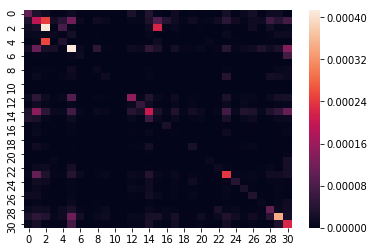

In [9]:
# Consider individual countries
_df = IO_MELT[(IO_MELT['input_country']=='DEU') & (IO_MELT['output_country']=='DEU')]

econ_flow_aus = build_economic_flow_cell(_df)

sbs.heatmap(nx.adjacency_matrix(econ_flow_aus,weight='val').toarray())
print(list(econ_flow_aus.nodes()))
#simulator.discrete_simulator(t_end=100,exogenous_node_vals={1:str_vals})


In [6]:
(np.sum(nx.adjacency_matrix(econ_flow_aus,weight='val').toarray(),axis=1)), econ_flow_aus.nodes()

(array([1.45166465e-04, 1.68894498e-04, 1.60590162e-04, 1.84033444e-05,
        3.49780039e-04, 7.12930558e-04, 6.88389730e-04, 1.76060630e-04,
        9.74566643e-05, 1.44144402e-04, 1.45075350e-05, 0.00000000e+00,
        4.44387576e-08, 7.39731028e-05, 5.42781933e-04, 3.41636042e-04,
        2.05360130e-05, 2.33290334e-04, 1.36843677e-04, 1.47888505e-04,
        1.52921244e-03, 1.06225724e-04, 1.71018779e-03, 3.14213756e-04,
        4.98537097e-04, 1.30761476e-05, 2.70129598e-04, 1.28800963e-04,
        1.01994591e-03, 1.52370907e-04, 8.39815943e-05]),
 NodeView(('DEU_01T03', 'DEU_22', 'DEU_17T18', 'DEU_13T15', 'DEU_28', 'DEU_49T53', 'DEU_64T66', 'DEU_27', 'DEU_19', 'DEU_31T33', 'DEU_05T06', 'DEU_97T98', 'DEU_09', 'DEU_16', 'DEU_86T88', 'DEU_41T43', 'DEU_85', 'DEU_20T21', 'DEU_90T96', 'DEU_58T60', 'DEU_69T82', 'DEU_55T56', 'DEU_All non-essential', 'DEU_10T12', 'DEU_35T39', 'DEU_84', 'DEU_62T63', 'DEU_23', 'DEU_45T47', 'DEU_61', 'DEU_26')))

In [7]:
# Identify exogenoeus nodes
simulator = CellDynamics(econ_flow_aus)

exog_nodes_dict_base = {}

for _node, _in_deg in econ_flow_aus.in_degree():
    if (_in_deg == 0):
        exog_nodes_dict_base[_node] = 1
    
    
simulator.fit_params(exog_nodes_dict_base)

exog_nodes_dict = {}

for _node,_in_deg in econ_flow_aus.in_degree():
    if (_in_deg == 0):
        exog_nodes_dict[_node] = 1-0.1*np.random.random(100)

exog_nodes_dict['DEU_01T03'] = np.hstack((1,1 - 0.2*np.random.random(99))) # PICKED A RANDOM NODE

    
#print(exog_nodes_dict)

#str_vals = np.random.random(100)
simulator.discrete_simulator(t_end=100,exogenous_node_vals=exog_nodes_dict)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


/opt/conda/envs/Python-3.6/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


20
21
22
23
24
25
26
27
28
29
30


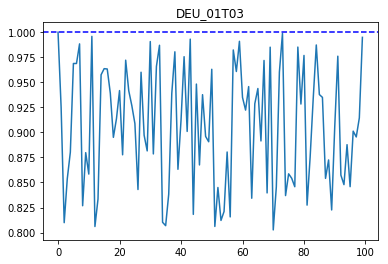

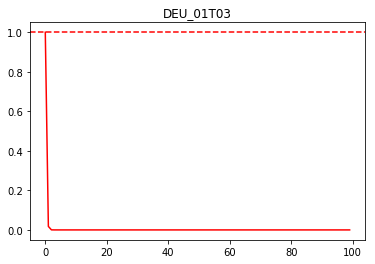

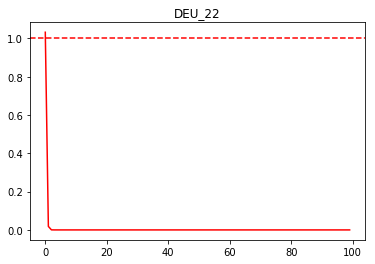

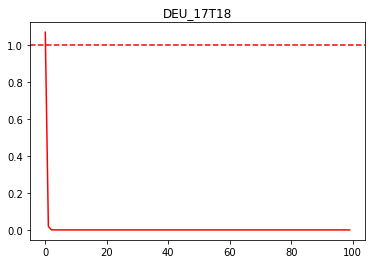

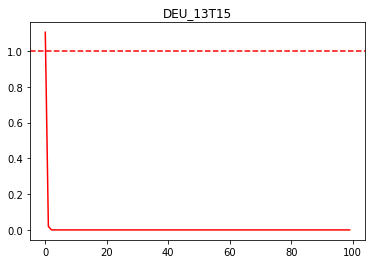

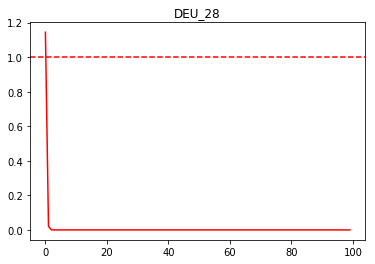

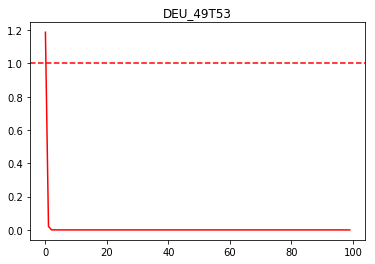

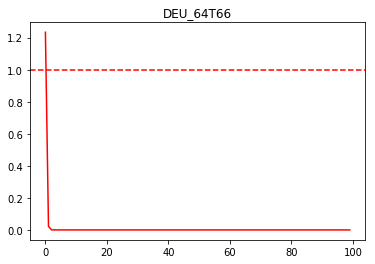

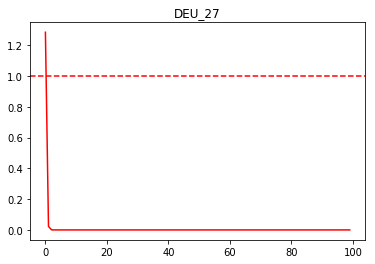

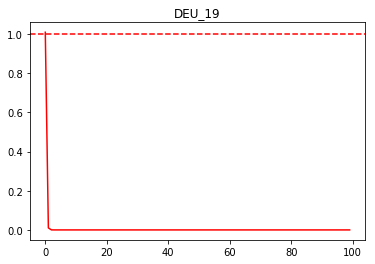

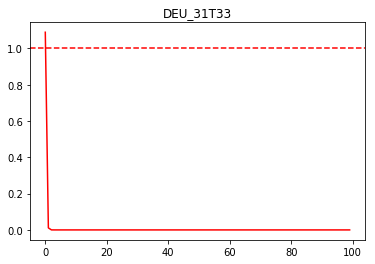

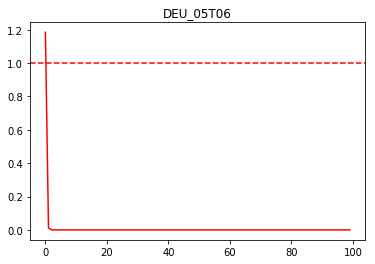

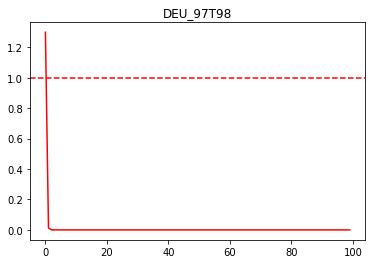

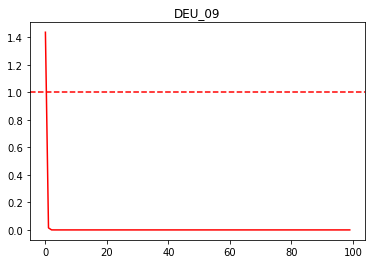

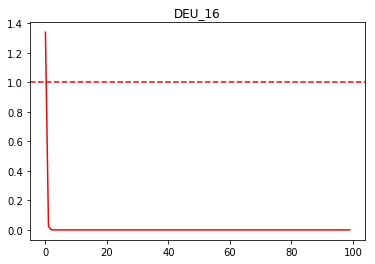

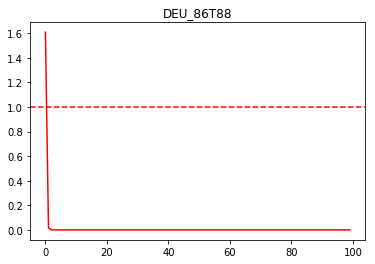

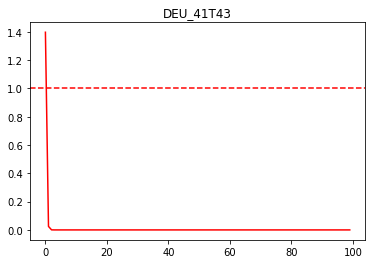

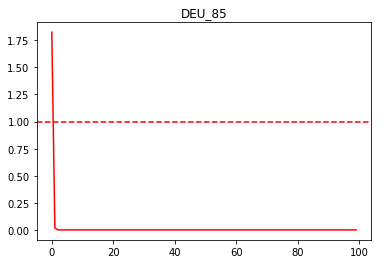

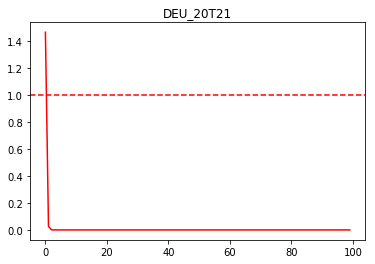

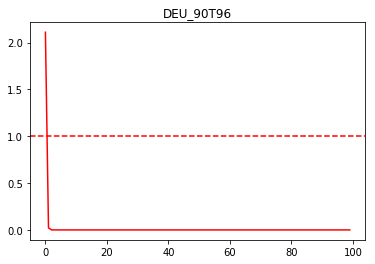

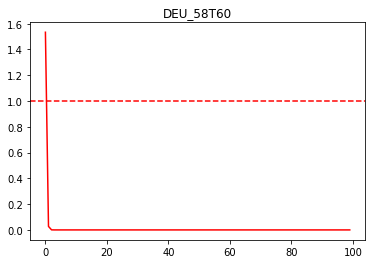

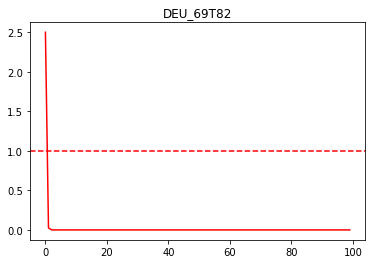

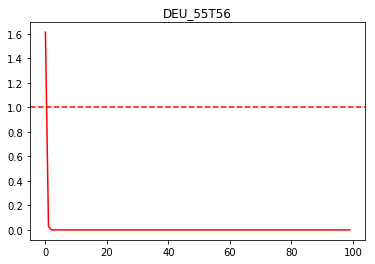

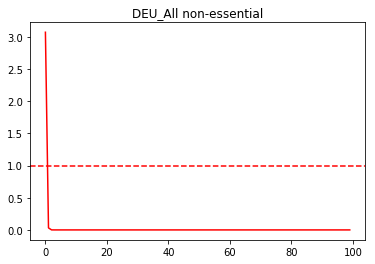

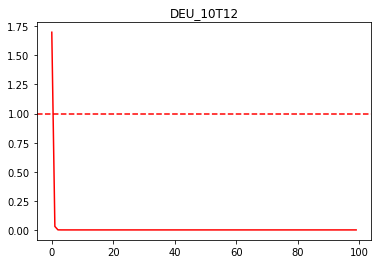

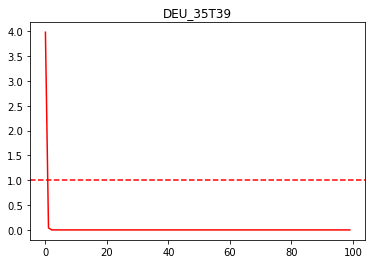

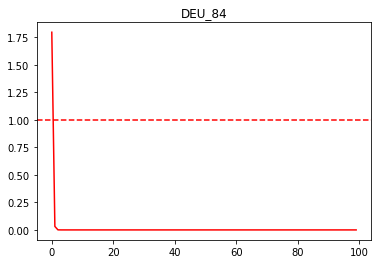

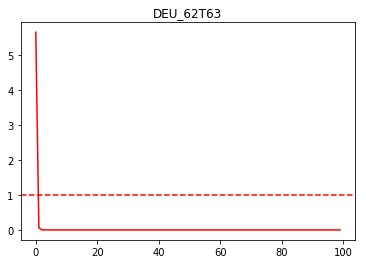

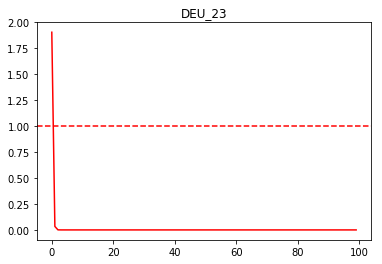

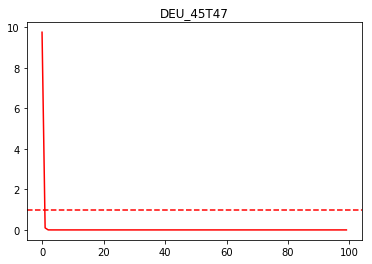

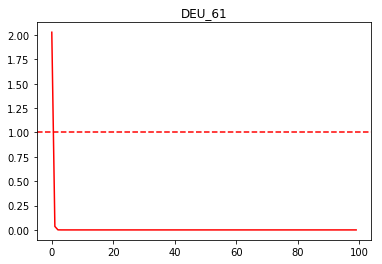

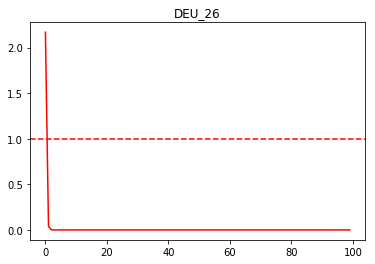

In [8]:
# Plot the exogeneous variables
import matplotlib.pyplot as plt
plt.figure()#(figsize=(12,8))
plt.plot(exog_nodes_dict['DEU_01T03'])
#help(plt.axhline)
plt.axhline(1,color='b',linestyle='--')
plt.title('DEU_01T03')

list_colors = ['g','r','b']
ctr = 0
nodes = []
for node in simulator.node_values.keys():
    #if ctr < 100:
    if len(simulator.node_values)>0:
        print(ctr)
        plt.figure()#(figsize=(12,8))
        #plt.plot(np.hstack((1,simulator.node_values[node][1:])),c='r')
        plt.plot(np.array(simulator.node_values[node][1:])/nx.get_node_attributes(simulator.sim_graph,'baseline')[node],c='r')
        plt.axhline(nx.get_node_attributes(simulator.sim_graph,'baseline')[node]/nx.get_node_attributes(simulator.sim_graph,'baseline')[node],color='r',linestyle='--')
        plt.title(node)
        ctr = ctr + 1
        nodes.append(node)
    #else:
    #    break

In [ ]:
nx.get_node_attributes(simulator.sim_graph,"baseline")

In [ ]:
import seaborn as sbs
sbs.heatmap(nx.adjacency_matrix(econ_flow_aus,weight='val').toarray())
list(econ_flow_aus.nodes())
#(econ_flow_aus.remove_edge(*('Coke and refined petroleum products', 'Mining support service activities')))

In [ ]:
help(econ_flow_aus.remove_edge)